# Custom Modelling with BIRDMAn - Longitudinal LME

One of the primary goals of BIRDMAn is to allow users to develop and implement their own statistical models based on their experimental design/question. For example, if you have paired or longitudinal data, you would likely want to specify random intercepts for individual subjects.

Here, we will do a fairly in-depth walkthrough of how you can use BIRDMAn to analyze longitudinal data. Note that for this workshop we will be using a custom Stan file, but in the future this file will be included as a default option.

## Data description

We will be using data from the study "Linking the effects of helminth infection, diet and the gut microbiota with human whole-blood signatures (repeated measurements)" (Qiita ID: 11913). This study looks at the effect of de-worming on the gut microbiome. Importantly, they collected pre and post-deworming stool samples on several individuals.

For our purposes, we would like to consider a linear mixed effects model (LME) where de-worming timepoint is a fixed effect and subject ID is a random effect. We will first process and explore the raw data.

In [1]:
%matplotlib inline

import biom
import numpy as np
import pandas as pd
import birdman

In [2]:
raw_tbl = biom.load_table("../data/helminth/94270_reference-hit.biom")
raw_tbl

2948 x 56 <class 'biom.table.Table'> with 8935 nonzero entries (5% dense)

In [3]:
metadata = pd.read_csv("../data/helminth/11913_20191016-112545.txt", sep="\t", index_col=0)
metadata.head()

,age,ascaris,collection_device,collection_method,collection_timestamp,date_of_collection,description,dna_extracted,elevation,elevation_units,...,sample_well,scientific_name,sex,site,taxon_id,time_point,title,trichuris,tube_id,villageaf
sample_name,,,,,,,,,,,,,,,,,,,,,
11913.101,15.0,0.0,Plastic container,By study subject,2013-05-08,May_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p03.C11,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,101,BF
11913.101AF,15.0,0.0,Plastic container,By study subject,2013-06-02,Jun_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p01.E7,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,101AF,AF
11913.102,50.0,0.0,Plastic container,By study subject,2013-05-08,May_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p03.C12,human gut metagenome,female,HumanGut,408170,1,"Linking the effects of helminth infection, die...",1.0,102,BF
11913.102AF,50.0,0.0,Plastic container,By study subject,2013-06-02,Jun_13,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,p01.E8,human gut metagenome,female,HumanGut,408170,2,"Linking the effects of helminth infection, die...",1.0,102AF,AF
11913.103AF,NaN,NaN,Plastic container,By study subject,2013-06-02,NaN,"Selangor, Rural Indigenous, Stool samples",True,not collected,meters,...,NaN,human gut metagenome,female,NaN,408170,2,"Linking the effects of helminth infection, die...",NaN,103AF,NaN


First, we want to determine which subjects have paired samples (taken at `time_point` 1 and 2).

In [4]:
metadata["host_subject_id"].unique()

array([  101,   102,   103,  1097,   119,  1248,  1259,  1287,   135,
        1372,  1383,   145, 15104,  1533,  1612,   166,  1719,  1758,
         181,  1875,  1889,  1892, 19100,  1998,  1999, 20109,  2093,
         218,   220,   221,   351,    37,   442,   445,   463,   511,
        5112,  5113,    52,   634,   762,   780,  8107,    88,   930,
         941,   953,    96,   969,    98,   995])

In [5]:
subj_is_paired = metadata.groupby("host_subject_id").apply(lambda x: (x["time_point"].values == [1, 2]).all())
paired_subjs = subj_is_paired[subj_is_paired].index
paired_subjs

Int64Index([   37,    52,    96,   102,   119,   135,   145,   166,   181,
              218,   220,   221,   351,   445,   463,   511,   780,   930,
              941,   953,  1097,  1248,  1259,  1383,  1533,  1612,  1719,
             1875,  1998,  8107, 19100, 20109],
           dtype='int64', name='host_subject_id')

In [6]:
paired_samps = metadata[metadata["host_subject_id"].isin(paired_subjs)].index

For this example we will consider only post/pre-deworm status.

In [7]:
cols_to_keep = ["time_point", "host_subject_id"]
metadata_model = metadata.loc[paired_samps, cols_to_keep].dropna()

Additionally, we are going to change the encoding of `time_point` to be more explicit. We are also going to prefix each subject ID with "S" so that they are read as strings instead of integers.

In [8]:
metadata_model["time_point"] = metadata_model["time_point"].map({1: "pre-deworm", 2: "post-deworm"})
metadata_model["host_subject_id"] = "S" + metadata["host_subject_id"].astype(str)

In [9]:
metadata_model.head()

,time_point,host_subject_id
sample_name,,
11913.102,pre-deworm,S102
11913.102AF,post-deworm,S102
11913.1097,pre-deworm,S1097
11913.1097AF,post-deworm,S1097
11913.119,pre-deworm,S119


## Filtering the feature table

We want to filter the original BIOM table to include only the samples we've specified. We are also going to reduce the number of microbes in the table to a more manageable number for this demonstration.

In [10]:
raw_tbl_df = raw_tbl.to_dataframe()
raw_tbl_df.iloc[:5, :5]

,11913.20109AF,11913.1383AF,11913.1097,11913.101AF,11913.634AF
TACGGAGGGTGCAAGCGTTAATCGGAATAACTGGGCGTAAAGGGCATGCAGGCGGTTCATCAAGTAGGATGTGAAATCCCCGGGCTCAAC,995.0,4355.0,1811.0,28.0,3229.0
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAAC,917.0,3345.0,516.0,827.0,5260.0
TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGATGCTCAAC,737.0,1761.0,273.0,1298.0,5845.0
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAAC,204.0,545.0,71.0,305.0,918.0
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAAC,122.0,79.0,573.0,321.0,246.0


In [11]:
samps_to_keep = sorted(list(set(raw_tbl_df.columns).intersection(metadata_model.index)))
len(samps_to_keep)

46

To filter out features, we calculate the prevalence of each feature and keep only features that appear in at least 20 samples out of 46.

In [12]:
filt_tbl_df = raw_tbl_df.loc[:, samps_to_keep]
prev = filt_tbl_df.clip(upper=1).sum(axis=1)
filt_tbl_df = filt_tbl_df.loc[prev[prev >= 20].index, :]
filt_tbl_df.shape

(88, 46)

Now we save this DataFrame as a BIOM so we can pass it into BIRDMAn.

In [13]:
filt_tbl = biom.table.Table(
    filt_tbl_df.values,
    sample_ids=filt_tbl_df.columns,
    observation_ids=filt_tbl_df.index
)
filt_tbl

88 x 46 <class 'biom.table.Table'> with 2730 nonzero entries (67% dense)

## LME Model

We have provided a Stan file with the code required to run this model. First, we'll print the contents to the screen.

In [14]:
with open("../models/negative_binomial_re.stan", "r") as f:
    print(f.read())

data {
  int<lower=0> N;                     // number of sample IDs
  int<lower=0> S;                     // number of groups (subjects)
  int<lower=0> D;                     // number of dimensions
  int<lower=0> p;                     // number of covariates
  real depth[N];                      // sequencing depths of microbes
  matrix[N, p] x;                     // covariate matrix
  int<lower=1, upper=S> subj_ids[N];  // mapping of samples to subject IDs
  int y[N, D];                        // observed microbe abundances
  real<lower=0> B_p;                  // stdev for covariate Beta Normal prior
  real<lower=0> phi_s;                // scale for dispersion Cauchy prior
  real<lower=0> u_p;                  // stdev for subject intercept Normal prior
}

parameters {
  matrix[p, D-1] beta;
  vector<lower=0>[D] reciprocal_phi;
  vector[S] subj_int;
}

transformed parameters {
  matrix[N, D-1] lam;
  matrix[N, D] lam_clr;
  vector<lower=0>[D] phi;

  for (i in 1:D){
    phi[i] =

### Description of the model

The basic Negative Binomial model is as follows:

$$ y_{ij} \sim \mathrm{NB}(\mu_{ij},\phi_j) $$

$$ \mu_{ij} = n_i p_{ij} $$

where $i$ is an arbitrary sample, $j$ is an arbitrary microbe, $n$ is the sampling depth, and $\phi$ is the dispersion parameter. We see that $\mu_{ij}$, the mean abundance of microbe $j$ in sample $i$, is the total sampling depth ($n_i$) multiplied by the probability of microbe $j$ in sample $i$.

For the default NB model, the probability for each microbe in a given sample is a function of only the fixed-effects. $x_i$ is the covariate matrix of sample $i$ and $\beta$ is the covariate coefficient vector (e.g. $[\beta_{\rm{intercept}}, \beta_{\rm{time}}, ...]^T$).

$$ \mathrm{alr}^{-1} (p_i) = x_i\beta $$

To include a random effect, we add a random intercept for each subject ID.

$$ \mathrm{alr}^{-1} (p_i) = x_i\beta + z_i u $$

where $z_i$ is the mapping of sample $i$ to subject and $u$ is the subject coefficient vector (e.g. $[u_{\textrm{S1}}, u_{\textrm{S2}}, ...]$)

In [15]:
nb_lme = birdman.Model(  # note that we are instantiating a base Model object
    table=filt_tbl,
    formula="C(time_point, Treatment('pre-deworm'))",
    metadata=metadata_model.loc[samps_to_keep],
    model_path="../models/negative_binomial_re.stan",
    num_iter=100,
    chains=4,
    seed=42
)

We then want to update our data dictionary with the new parameters.

By default BIRDMAn computes and includes:

* `y`: table data
* `x`: covariate design matrix
* `depth`: log sampling depths of samples
* `N`: number of samples
* `D`: number of features
* `p`: number of covariates (including Intercept)

We want to add the necessary variables to be passed to Stan:

* `S`: total number of groups (subjects)
* `B_p`: mapping of samples to subject
* `phi_s`: stdev prior for normally distributed covariate-feature coefficients
* `u_p`: scale prior for half-Cauchy distributed overdispersion coefficients
* `subj_ids`: stdev prior for normally distributed subject intercept shifts

We want to provide `subj_ids` with a mapping of which sample corresponds to which subject. Stan does not understand strings so we encode each unique subject as an integer (starting at 1 because Stan 1-indexes arrays).

In [16]:
group_var_series = metadata_model.loc[samps_to_keep]["host_subject_id"]
samp_subj_map = group_var_series.astype("category").cat.codes + 1

samp_subj_map.head(10)

sample_name
11913.102       1
11913.102AF     1
11913.1097      2
11913.1097AF    2
11913.1248      3
11913.1248AF    3
11913.1259      4
11913.1259AF    4
11913.1383      5
11913.1383AF    5
dtype: int8

In [17]:
groups = np.sort(group_var_series.unique())
groups

array(['S102', 'S1097', 'S1248', 'S1259', 'S1383', 'S1533', 'S1612',
       'S1719', 'S19100', 'S1998', 'S20109', 'S218', 'S220', 'S221',
       'S351', 'S37', 'S445', 'S463', 'S511', 'S780', 'S930', 'S953',
       'S96'], dtype=object)

In [18]:
param_dict = {
    "S": len(groups),
    "subj_ids": samp_subj_map.values,
    "B_p": 3.0,
    "phi_s": 3.0,
    "u_p": 1.0
}

nb_lme.add_parameters(param_dict)

We can see the input data with `nb_lme.dat`. This is the dictionary that is passed into Stan. Note how each of the entries in this dictionary correspond to an entry in the `data` block of the Stan code.

In [19]:
nb_lme.dat

{'y': matrix([[  42, 2354, 1642, ...,    0,    0,    0],
         [  17, 3112, 1832, ...,    0,    2,    0],
         [1811,  516,  273, ...,    0,    0,    0],
         ...,
         [3002, 4058, 2299, ...,    3,    0,    1],
         [ 838, 8846, 2903, ...,   16,    8,    6],
         [ 998, 3726, 1795, ...,    0,    0,    4]]),
 'D': 88,
 'N': 46,
 'p': 2,
 'depth': array([9.73329218, 9.05742227, 8.81700144, 8.9183825 , 9.15037803,
        8.89192414, 8.14380798, 9.23190615, 8.96226355, 9.41751713,
        9.19410936, 9.60245003, 8.52098599, 8.87807926, 8.95454449,
        9.09481728, 8.59415423, 8.91489491, 9.25951142, 8.59951023,
        8.84635304, 8.40200678, 9.31045716, 9.22128031, 9.06797003,
        9.33838172, 8.8503743 , 9.78284418, 8.76701762, 9.11493019,
        9.52930306, 9.64853078, 9.43691802, 9.5888453 , 8.31164395,
        9.07772285, 8.59359852, 9.13852208, 8.70582811, 9.27883979,
        8.43010908, 9.67940606, 9.00650913, 9.31901539, 9.99442455,
        9.1018639

In [20]:
nb_lme.compile_model()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/gibs/projects/birdman-demo/models/negative_binomial_re


In [21]:
%%time

nb_lme.fit_model()

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


CPU times: user 582 ms, sys: 58 ms, total: 640 ms
Wall time: 28.4 s


In [22]:
nb_lme.diagnose();

INFO:cmdstanpy:Processing csv files: /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp0vun36fz/negative_binomial_re-202103280040-1-2eq9qxiv.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp0vun36fz/negative_binomial_re-202103280040-2-fwkgyz0s.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp0vun36fz/negative_binomial_re-202103280040-3-r2gfllx3.csv, /var/folders/1c/vd4s85fn44q78l5vrmmwn06c0000gn/T/tmp0vun36fz/negative_binomial_re-202103280040-4-v8mb2ugb.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  y_predict[24,65]
Such high values indicate incomplete mixing and biasedestimation.
You should consider regularizating your model with additional prior inf

Now we will again transform this fitted model into an `arviz` inference object. Here we specify that we have another parameter of interest, `subj_int` of dimensions `subjects`.

In [23]:
inference = nb_lme.to_inference_object(
    params=["beta", "phi", "subj_int"],
    coords={
        "feature": nb_lme.feature_names,
        "covariate": nb_lme.colnames,
        "subject": groups
    },
    dims={
        "beta": ["covariate", "feature"],
        "phi": ["feature"],
        "subj_int": ["subject"]
    },
    alr_params=["beta"],
    posterior_predictive="y_predict",
    log_likelihood="log_lik",
    include_observed_data=True
)

In [24]:
import birdman.diagnostics as diag

diag.loo(inference, pointwise=True)

/Users/gibs/miniconda3/envs/birdman/lib/python3.7/site-packages/arviz/stats/stats.py:653: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 400 by 4048 log-likelihood matrix

         Estimate       SE
elpd_loo -14905.10   155.70
p_loo      254.83        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3949   97.6%
 (0.5, 0.7]   (ok)         81    2.0%
   (0.7, 1]   (bad)        18    0.4%
   (1, Inf)   (very bad)    0    0.0%

We can now verify that the dimensions of our subject intercepts are (chain x draw x subject).

In [25]:
inference.posterior["subj_int"].dims

('chain', 'draw', 'subject')

In [26]:
inference.posterior.coords["covariate"].values

array(['Intercept',
       "C(time_point, Treatment('pre-deworm'))[T.post-deworm]"],
      dtype=object)

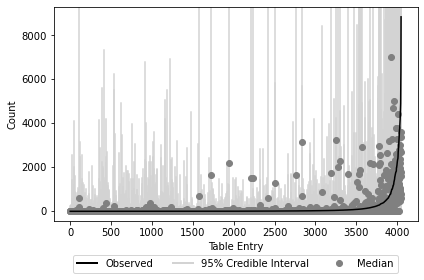

In [27]:
from birdman.visualization import plot_posterior_predictive_checks

ax = plot_posterior_predictive_checks(inference)

For this notebook we'll look at differential taxa by post-deworm status.

In [28]:
deworm_diff = inference.posterior["beta"].sel(
    {"covariate": "C(time_point, Treatment('pre-deworm'))[T.post-deworm]"}
)
deworm_diff = deworm_diff.stack(mcmc_sample=("chain", "draw"))
deworm_diff_means = deworm_diff.mean(dim="mcmc_sample")
deworm_diff_stds = deworm_diff.std(dim="mcmc_sample")

In [29]:
sorted_deworm_diff_means = deworm_diff_means.sortby(deworm_diff_means)
sorted_deworm_diff_means

<xarray.DataArray 'beta' (feature: 88)>
array([-2.46478577, -1.69512548, -1.37817681, -1.32298247, -1.31094608,
       -1.13537057, -1.08588968, -1.07657731, -0.9232941 , -0.86684728,
       -0.79534875, -0.73874434, -0.70865246, -0.68615234, -0.6653098 ,
       -0.62815381, -0.60408235, -0.5729797 , -0.4313488 , -0.410583  ,
       -0.3822664 , -0.37263546, -0.37018474, -0.35202177, -0.32738855,
       -0.32433081, -0.31306102, -0.31093225, -0.28566328, -0.23330058,
       -0.22337411, -0.22057181, -0.20629276, -0.18788811, -0.1812819 ,
       -0.14987975, -0.14408073, -0.12653829, -0.10147093, -0.10050677,
       -0.06480637, -0.02737752,  0.03511848,  0.03722411,  0.04489603,
        0.05521896,  0.07859627,  0.09192131,  0.12172158,  0.1274048 ,
        0.13166914,  0.16242287,  0.18379463,  0.1912052 ,  0.19254754,
        0.20541254,  0.2248786 ,  0.2333704 ,  0.2375052 ,  0.23986714,
        0.37615193,  0.37840281,  0.41954148,  0.42126116,  0.44297256,
        0.4566406 ,  0.4630838 ,  0.4922133 ,  0.52384774,  0.52451548,
        0.56378313,  0.57591525,  0.59364377,  0.60526606,  0.65772346,
        0.78755576,  0.79303635,  0.8181217 ,  0.91505608,  0.92326136,
        0.92436216,  0.94177514,  1.01348833,  1.13276778,  1.19368264,
        1.27371843,  1.47478747,  2.22585422])
Coordinates:
  * feature    (feature) object 'TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCG...
    covariate  <U53 "C(time_point, Treatment('pre-deworm'))[T.post-deworm]"

In [30]:
n = 8
bottom_feats = sorted_deworm_diff_means[:n].coords["feature"].values
top_feats = sorted_deworm_diff_means[-n:].coords["feature"].values

In [31]:
import numpy as np

def log_ratio(table, top_feats, bot_feats):
    num_df = table.loc[:, top_feats].sum(axis=1).to_frame()
    num_df.columns = ["num"]
    num_df = num_df[num_df["num"] > 0]
    denom_df = table.loc[:, bot_feats].sum(axis=1).to_frame()
    denom_df.columns = ["denom"]
    denom_df = denom_df[denom_df["denom"] > 0]
    lr_df = num_df.join(denom_df, how="inner")
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"])
    return lr_df

lr_df = log_ratio(filt_tbl_df.T, top_feats, bottom_feats).join(metadata_model, how="inner")
print(lr_df.shape)
lr_df.head()

(46, 5)


,num,denom,log_ratio,time_point,host_subject_id
11913.102,457.0,131.0,1.249486,pre-deworm,S102
11913.102AF,1542.0,11.0,4.942940,post-deworm,S102
11913.1097,38.0,127.0,-1.206601,pre-deworm,S1097
11913.1097AF,455.0,46.0,2.291656,post-deworm,S1097
11913.1248,64.0,2971.0,-3.837771,pre-deworm,S1248


In [32]:
func = lambda x: (
    x.query("time_point == 'post-deworm'")["log_ratio"][0] 
    - x.query("time_point == 'pre-deworm'")["log_ratio"][0]
)

lr_diffs = (
    lr_df
    .groupby("host_subject_id")
    .apply(func)
)
lr_diffs.head()

host_subject_id
S102     3.693454
S1097    3.498257
S1248    4.070393
S1259    0.393011
S1383    5.431858
dtype: float64

Finally, we'll plot the log-ratio changes from pre-deworm to post-deworm and include `life_stage` as a factor in our visualization.

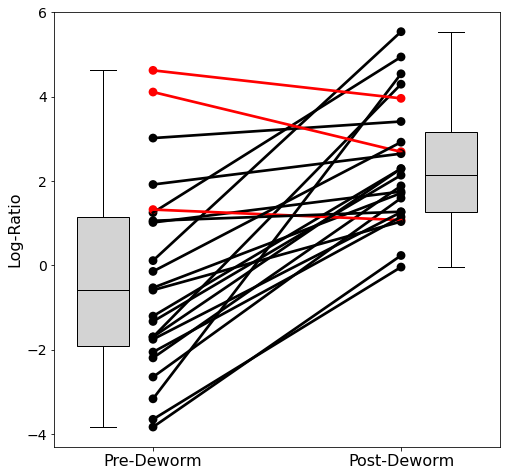

In [33]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")

for subj_id, subj_df in lr_df.groupby("host_subject_id"):
    _d = lr_diffs[subj_id]
    
    args = {
        "data": subj_df,
        "x": "time_point",
        "y": "log_ratio",
        "color": "black" if _d > 0 else "red"
    }
    sns.pointplot(**args, ax=ax)

ax.set_xlim([-0.4, 1.4])

pre_deworm_lrs = lr_df.query("time_point == 'pre-deworm'")["log_ratio"].values
post_deworm_lrs = lr_df.query("time_point == 'post-deworm'")["log_ratio"].values

bplot = ax.boxplot(
    [pre_deworm_lrs, post_deworm_lrs],
    positions=[-0.2, 1.2],
    patch_artist=True
)

for patch in bplot["boxes"]:
    patch.set_facecolor("lightgray")
for med in bplot["medians"]:
    med.set_color("black")

    
ax.set_xticks([0, 1])
ax.set_xticklabels(["Pre-Deworm", "Post-Deworm"], fontsize=16)
ax.tick_params("y", labelsize=14)
ax.set_xlabel("")
ax.set_ylabel("Log-Ratio", fontsize=16)

plt.show()

In [34]:
import scipy.stats as ss

ss.wilcoxon(lr_diffs)

WilcoxonResult(statistic=13.0, pvalue=2.09808349609375e-05)

We see that, indeed, this auto-selected log-ratio separates post-deworm from pre-deworm paired samples.

That's it for this notebook. There's a lot of possibilities with BIRDMAn depending on your specific experimental design and questions.

For instance, here we decided that each subject should have an individual random intercept, but what if we wanted to see how each microbe changes with each subject? We could augment the model by changing the `subj_int` parameters to `matrix[S, D-1]`. Note that in this case we could have to tweak the arguments to `nb_lme.to_inference_object` to specify the new dimensions and that this parameter is in ALR coordinates.

This updated model specification is included in BIRDMAn by default under the name `NegativeBinomialLME`.